## 1.インポート&定義

In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
from urllib.request import urlopen
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from selenium.webdriver import Chrome,ChromeOptions

In [170]:
def scrape_race_results(race_id_list, pre_race_results={}):
    #race_results = pre_race_results
    race_results = pre_race_results.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/race/" + race_id
            race_results[race_id] = pd.read_html(url)[0]
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return race_results

#レース条件のデータ取り出し関数
def scrape_race_info(race_id_list):
    race_infos={}

    for race_id in tqdm(race_id_list):
        try:
            url = 'https://db.netkeiba.com/race/' + race_id
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text,'html.parser')

            texts = soup.find("div",attrs = {'class':'data_intro'}).find_all('p')[0].text + \
                soup.find("div",attrs = {'class':'data_intro'}).find_all('p')[1].text
            info = re.findall(r"\w+",texts)
            info_dict = {}
            for text in info:
                if text in ['芝','ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = int(re.findall(r'\d+',text)[0])
                if text in ['良','稍重','重','不良']:
                    info_dict['ground_state'] = text
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text

            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except:
            break
    return race_infos
    
def scrape_race_results2(race_id_list, pre_race_results={}):
    #race_results = pre_race_results
    race_results = pre_race_results.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            #race_results[race_id] = pd.read_html(url)[0]
            df = pd.read_html(url)[0]
            #soup = BeautifulSoup(html.text,'html.parser')

            #horse_idとjockey_idをスクレイピング
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup =BeautifulSoup(html.text,"html.parser")
            #horse_id
            horse_id_list = []
            horse_a_list = soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+',a['href'])
                horse_id_list.append(horse_id[0])

            #jockey_id
            jockey_id_list = []
            jockey_a_list = soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+',a['href'])
                jockey_id_list.append(jockey_id[0])

            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
            time.sleep(1)
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return race_results
    
def scrape_horse_results2(horse_id_list, pre_horse_results={}):
    #race_results = pre_race_results
    horse_results = pre_horse_results.copy() #正しくはこちら。注意点で解説。
    for horse_id in tqdm(horse_id_list):
        if horse_id in horse_results.keys():
            continue
        try:
            url = "https://db.netkeiba.com/horse/" + horse_id
            df = pd.read_html(url)[3]
            #if "受賞歴" in df['受賞歴']:
             #   df = pd.read_html(url)[4]
            if df.columns[0]=='受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
            time.sleep(1)
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return horse_results

def scrape_return_tables(race_id_list, pre_return_tables={}):
    #return_tables = pre_return_tables
    return_tables = pre_return_tables.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in return_tables.keys():
            continue
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            f =urlopen(url)
            html = f.read()
            html = html.replace(b'<br />',b'br')
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1],dfs[2]])
            time.sleep(1)
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return return_tables

#pickleデータの読み込み
#results = pd.read_pickle('results.pickle')
results2 = pd.read_pickle('results_addinfo.pickle')
#データの分別
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df['着順'] = pd.to_numeric(df['着順'],errors='coerce')
    df.dropna(subset=['着順'],inplace=True)
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)
    df["course_len"] = df["course_len"].astype(int)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重",'馬名','騎手'], axis=1, inplace=True)

    #新しい規格
    df['date'] = pd.to_datetime(df['date'],format='%Y年%m月%d日')

    return df

#ダミーデータの生成
def split_data(df,test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list].drop(['date'],axis=1)
    test = df.loc[test_id_list].drop(['date'],axis=1)
    return train,test

class HorseResults:
    def __init__(self,horse_results):
        self.horse_results = horse_results[['日付','着順','賞金']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'},inplace=True)

    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'],errors='coerce')
        df.dropna(subset=['着順'],inplace=True)
        #df = df[~(df["着順"].astype(str).str.contains("\D"))]
        df["着順"] = df["着順"].astype(int)

        #新しい規格
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'],axis=1,inplace=True)

        #賞金のNaNを0で埋める
        df['賞金'].fillna(0,inplace=True)

        self.horse_results = df
    def average(self,horse_id_list,date,n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]

        #過去何年分のデータを取り出すかの設定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date',ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception['n_samples must be >0']
        
        average = filtered_df.groupby(level = 0)[['着順','賞金']].mean()
        return average.rename(columns={'着順':'着順_{}R'.format(n_samples),'賞金':'賞金_{}R'.format(n_samples)})

    def merge(self,results,date,n_samples = 'all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list,date,n_samples),left_on='horse_id',right_index=True,how='left')
        return merged_df
    def merge_all(self,results,n_samples = 'all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results,date,n_samples)for date in tqdm(date_list)])
        return merged_df

class Return:
    def __init__(self,return_tables):
        self.return_tables = return_tables
        #self.fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        
    #変数のように使える()が必要ない
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br',expand=True).drop([3],axis=1)
        wins.columns = ['win_0','win_1','win_2']
        returns = fukusho[2].str.split('br',expand=True).drop([3],axis=1)
        returns.columns = ['return_0','return_1','return_2']

        df = pd.concat([wins,returns],axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2]]
        tansho.columns = ['win','return']

        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column],errors='coerce')
        return tansho

#_idを使うため不要になった馬名と騎手を切り捨て
def prefix(results_fix):
    df = results_fix.copy()

    df.drop(['馬名','騎手'], axis=1, inplace=True)
    return df

class ModelEvaluator:
    def __init__(self,model,return_tables,std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std
    
    def predict_proba(self,x):
        proba = pd.Series(self.model.predict_proba(x)[:,1], index=x.index)
        if self.std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba

    def predict(self,x,threshold=0.5):
        y_pred = self.predict_proba(x)
        return [0 if p<threshold else 1 for p in y_pred]

    def score(self,y_true,x):
        return roc_auc_score(y_true,self.predict_proba(x))

    def feature_importance(self,x,n_display=20):
        importances = pd.DataFrame({'features':x_train.columns,
                                    'importance':self.model.feature_importances_})
        return importances.sort_values('importance',ascending=False)[:n_display]

    def pred_table(self,x,threshold=0.5,bet_only=True):
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x,threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
    
    def fukusho_return(self,x,threshold=0.5):
        pred_table = self.pred_table(x,threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table,left_index=True, right_index=True,how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets,money
    def tansho_return(self,x,threshold=0.5):
        pred_table = self.pred_table(x,threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table,left_index=True, right_index=True,how='right')
        money += df[df['win']==df['馬番']]['return'].sum()
        return n_bets,money

def gain(return_func,x,n_samples=100,lower=50,min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1*i/n_samples + min_threshold * (1-i/n_samples)
        n_bets,money = return_func(x,threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets*100 + money)/(n_bets*100)
    return pd.Series(gain)

def process_categorical(df,target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    #target_columns以外にカテゴリ変数があれば、ダミー変数にする
    df2 = pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column] = df2[column].astype('category')
    return df2

In [34]:
return_tables = pd.read_pickle('return_tables.pickle')
rt = Return(return_tables)
rt.tansho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1036 entries, 201906040103 to 201906050907
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   win     1035 non-null   float64
 1   return  1035 non-null   float64
dtypes: float64(2)
memory usage: 24.3+ KB


In [35]:
results = pd.read_pickle('results_id.pickle')
horse_results = pd.read_pickle('horse_data2.pickle')

In [36]:
results = prefix(results)
results_p = results
results_p.head()

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化
201901010101,1,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16
201901010101,2,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8
201901010101,3,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6
201901010101,4,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8
201901010101,5,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0


In [37]:
hr = HorseResults(horse_results)
results_m = hr.merge_all(results_p,n_samples=5)
results_m = hr.merge_all(results_m,n_samples=9)
results_m = hr.merge_all(results_m,n_samples='all')
results_m.head()

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,...,性,年齢,体重,体重変化,着順_5R,賞金_5R,着順_9R,賞金_9R,着順_allR,賞金_allR
201901010101,1,1,1,54.0,1.4,1.0,1800,曇,芝,良,...,牡,2,518,-16,3.0,180.0,3.0,180.0,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,1800,曇,芝,良,...,牡,2,496,-8,2.0,280.0,2.0,280.0,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,1800,曇,芝,良,...,牡,2,546,6,10.0,0.0,10.0,0.0,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,1800,曇,芝,良,...,牡,2,458,-8,4.0,110.0,4.0,110.0,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,1800,曇,芝,良,...,牡,2,436,0,9.0,0.0,9.0,0.0,9.0,0.0


In [38]:
peds = pd.read_pickle('peds.pickle')
results_m = results_m.merge(peds,left_on='horse_id',right_index=True,how='left')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,1,54.0,1.4,1.0,1800,曇,芝,良,...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,2,3,3,54.0,3.5,2.0,1800,曇,芝,良,...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,3,4,4,51.0,46.6,6.0,1800,曇,芝,良,...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
201901010101,4,8,9,51.0,56.8,7.0,1800,曇,芝,良,...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
201901010101,5,5,5,54.0,140.3,9.0,1800,曇,芝,良,...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania


In [39]:
categorical_columns = ['horse_id'] + ['peds_{}'.format(i) for i in range(62)]
results_d = process_categorical(results_m,categorical_columns)

In [40]:
results_d['rank'] = results_d['着順'].map(lambda x:1 if x<4 else 0)
results_r = results_d.drop(['着順','単勝','人気'],axis=1)#,inplace=True)

↑まで

In [42]:
train,test = split_data(results_r)
x_train = train.drop(['rank'],axis=1)
y_train = train['rank']
x_test = test.drop(['rank'],axis=1)
y_test = test['rank']
x_train.head()

,枠番,馬番,斤量,course_len,horse_id,年齢,体重,体重変化,着順_5R,賞金_5R,...,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201906010101,5,9,56.0,1200,5510,3,500,14,3.0,180.000000,...,0,0,0,0,0,0,0,0,0,1
201906010101,7,14,52.0,1200,7339,3,448,10,8.5,37.500000,...,0,0,0,0,0,0,0,0,1,0
201906010101,5,10,56.0,1200,6078,3,454,6,5.2,76.000000,...,0,0,0,0,0,0,0,0,0,1
201906010101,3,6,54.0,1200,7078,3,474,-2,3.0,151.666667,...,0,0,0,0,0,0,0,0,1,0
201906010101,4,8,56.0,1200,5993,3,438,4,4.5,81.250000,...,0,0,0,0,0,0,0,0,0,1


In [43]:
params = {
    'num_leaves':4,
    'n_estimators':80,
    #'min_data_in_leaf':15,
    'class_weight':'balanced',
    'random_leaves':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(x_train.values,y_train.values)
y_pred_train = lgb_clf.predict_proba(x_train)[:,1]
y_pred = lgb_clf.predict_proba(x_test)[:,1]
print(roc_auc_score(y_train,y_pred_train))
print(roc_auc_score(y_test,y_pred))

[LightGBM] [Warning] Unknown parameter: random_leaves
0.7359061633093273
0.7096292607750416


In [44]:
me =ModelEvaluator(lgb_clf,return_tables)
me.feature_importance(x_test,10)

,features,importance
8,着順_5R,31
4,horse_id,23
9,賞金_5R,21
12,着順_allR,18
6,体重,13
241,jockey_id_05339,12
149,jockey_id_01088,10
2,斤量,9
10,着順_9R,8
245,jockey_id_05386,7


In [45]:
baseline = gain(me.tansho_return,x_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

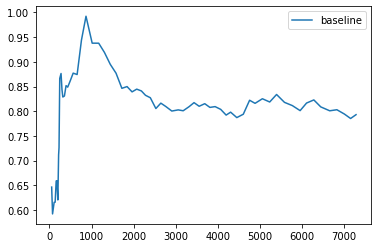

In [46]:
baseline.rename('baseline').plot(legend=True)

In [48]:
me.predict_proba(x_test)

array([0.62517339, 0.48798711, 0.42774562, ..., 0.23078418, 0.52957892,
       0.1173882 ])

In [50]:
proba_table = x_test[['horse_id']].copy()
proba_table['proba'] = me.predict_proba(x_test)
proba_table

,horse_id,proba
201909040104,10663,0.625173
201909040104,8494,0.487987
201909040104,8347,0.427746
201909040104,11065,0.604138
201909040104,9465,0.418844
...,...,...
201909050902,10254,0.280523
201909050902,8485,0.266709
201909050902,8919,0.230784
201909050902,10352,0.529579


In [51]:
proba_table['R'] = proba_table.index.map(lambda x:str(x)[-2:])
proba_table

,horse_id,proba,R
201909040104,10663,0.625173,04
201909040104,8494,0.487987,04
201909040104,8347,0.427746,04
201909040104,11065,0.604138,04
201909040104,9465,0.418844,04
...,...,...,...
201909050902,10254,0.280523,02
201909050902,8485,0.266709,02
201909050902,8919,0.230784,02
201909050902,10352,0.529579,02


In [52]:
proba_table.groupby('R')['proba'].mean()

R
01    0.390112
02    0.447505
03    0.468792
04    0.466651
05    0.497443
06    0.488063
07    0.508928
08    0.522037
09    0.559513
10    0.537799
11    0.544138
12    0.502007
Name: proba, dtype: float64

## 2.標準化

In [53]:
proba_table.loc['201909040104']['proba']

201909040104    0.625173
201909040104    0.487987
201909040104    0.427746
201909040104    0.604138
201909040104    0.418844
201909040104    0.469415
201909040104    0.510863
201909040104    0.537011
201909040104    0.472347
201909040104    0.454682
201909040104    0.410728
201909040104    0.323402
201909040104    0.427746
201909040104    0.423747
Name: proba, dtype: float64

In [55]:
x = proba_table.loc['201909040104']['proba']

平均
$$ \mu = E(X) = \frac{1}{14}\left(X_1 + X_2 + \cdots + X_{14} \right)$$

In [56]:
x.count()

14

In [57]:
x.mean()

0.470987759569548

分散:平均点を中心に、データがどのくらいばらついているか
$$ V(X) = \frac{1}{14}\left((X_1-E(X)^2 + (X_2-E(X))^2 + \cdots + (X_{14}-E(X))^2 \right)$$

In [58]:
x.var()

0.006316449474895871

標準偏差
$$ \sigma \equiv \sqrt{V(X)}$$

In [59]:
x.std()

0.07947609373198881

標準化

In [61]:
x_std = (x-x.mean()) / x.std()
x_std

201909040104    1.940025
201909040104    0.213893
201909040104   -0.544090
201909040104    1.675353
201909040104   -0.656090
201909040104   -0.019787
201909040104    0.501724
201909040104    0.830729
201909040104    0.017097
201909040104   -0.205160
201909040104   -0.758213
201909040104   -1.856989
201909040104   -0.544090
201909040104   -0.594401
Name: proba, dtype: float64

In [62]:
x_std.sum()

-4.9960036108132044e-15

In [63]:
x_std.var()

0.9999999999999999

### 2.1.transformとapply

In [64]:
proba_table

,horse_id,proba,R
201909040104,10663,0.625173,04
201909040104,8494,0.487987,04
201909040104,8347,0.427746,04
201909040104,11065,0.604138,04
201909040104,9465,0.418844,04
...,...,...,...
201909050902,10254,0.280523,02
201909050902,8485,0.266709,02
201909050902,8919,0.230784,02
201909050902,10352,0.529579,02


In [65]:
proba_table.groupby(level=0)['proba'].apply(np.sum)

201903030101    5.439697
201903030102    5.544874
201903030103    5.008343
201903030104    4.672887
201903030105    8.174166
                  ...   
201909050908    8.873634
201909050909    7.822005
201909050910    8.944699
201909050911    7.935662
201909050912    7.016888
Name: proba, Length: 1036, dtype: float64

In [67]:
proba_table.groupby(level=0)['proba'].transform(np.sum)#.loc['201903030101']

201909040104    6.593829
201909040104    6.593829
201909040104    6.593829
201909040104    6.593829
201909040104    6.593829
                  ...   
201909050902    6.467692
201909050902    6.467692
201909050902    6.467692
201909050902    6.467692
201909050902    6.467692
Name: proba, Length: 13997, dtype: float64

In [69]:
standard_scaler = lambda x: (x - x.mean()) / x.std()
proba_table.groupby(level=0)['proba'].transform(standard_scaler)

201909040104    1.940025
201909040104    0.213893
201909040104   -0.544090
201909040104    1.675353
201909040104   -0.656090
                  ...   
201909050902   -0.657441
201909050902   -0.730857
201909050902   -0.921776
201909050902    0.666159
201909050902   -1.524416
Name: proba, Length: 13997, dtype: float64

<AxesSubplot:>

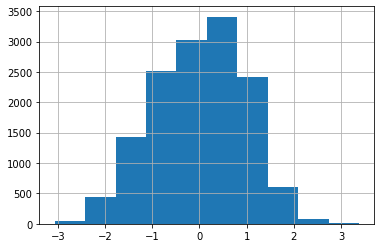

In [71]:
proba_std = proba_table.groupby(level=0)['proba'].transform(standard_scaler)
proba_std.hist()

MinMaxスケーリング:データを0から1にする

<AxesSubplot:>

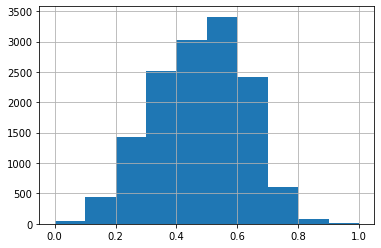

In [73]:
proba_minmax = (proba_std - proba_std.min()) / (proba_std.max() - proba_std.min())
proba_minmax.hist()

### 2.2.実装

In [89]:
me = ModelEvaluator(lgb_clf,return_tables,std=True)

In [90]:
gain_std = gain(me.tansho_return,x_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

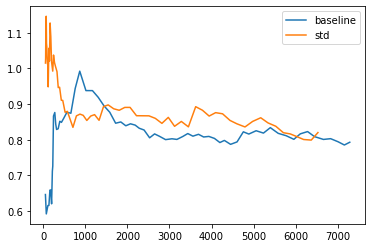

In [92]:
baseline.rename('baseline').plot(legend=True)
gain_std.rename('std').plot(legend=True)

In [93]:
gain_std.max()

1.1464788732394366

In [96]:
gain_std[50:]

268    1.016418
245    1.037551
226    0.992478
197    1.019797
180    1.089444
163    1.127607
148    1.020946
134    1.056716
118    0.948305
109    1.010092
101    1.012871
93     1.032258
85     1.061176
78     1.070513
71     1.146479
63     1.119048
57     1.028070
53     1.015094
dtype: float64

In [97]:
x_test.index.nunique()

1036

In [101]:
np.sum(me.predict(x_test,threshold=0.82))

71

In [103]:
me.pred_table(x_test,threshold=0.82)

201909040208     7
201909040203     8
201909040201     6
201906040305     4
201906040405    13
                ..
201909050705    16
201906050802    14
201906050905     9
201909050905    10
201909050904    13
Name: 馬番, Length: 71, dtype: int64

In [ ]:
_, sample = split_data(results_m)
sample

In [105]:
bets = sample[['着順','人気','単勝','馬番']]\
    .merge(me.pred_table(x_test,threshold=0.82),left_index=True,right_index=True,how='right')

In [106]:
bets

,着順,人気,単勝,馬番_x,馬番_y
201905040104,1,7.0,21.3,5,8
201905040104,2,3.0,7.0,16,8
201905040104,3,6.0,19.1,11,8
201905040104,4,2.0,4.3,6,8
201905040104,5,5.0,12.8,4,8
...,...,...,...,...,...
201909050905,6,6.0,31.6,3,10
201909050905,7,9.0,89.8,6,10
201909050905,8,7.0,74.2,7,10
201909050905,9,10.0,92.3,4,10


In [107]:
bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()

1.0    34
2.0    17
3.0     7
4.0     6
7.0     3
6.0     2
5.0     2
Name: 人気, dtype: int64

↑何番人気にかけているか

In [110]:
bets[(bets['馬番_x'] == bets['馬番_y'])&(bets['着順']==1)]['人気'].value_counts()

1.0    15
2.0     6
3.0     1
4.0     1
7.0     1
Name: 人気, dtype: int64

In [111]:
len(bets[(bets['馬番_x'] == bets['馬番_y'])&(bets['着順']==1)])

24

In [113]:
24/71*100

33.80281690140845

In [114]:
len(sample[sample['人気']==1&(sample['着順']==1)])

342

In [115]:
342/1036*100

33.011583011583014

In [118]:
rt = Return(return_tables)
rt.tansho

,win,return
201906040103,6.0,750.0
201906040102,5.0,1240.0
201906040104,1.0,160.0
201906040106,8.0,420.0
201906040105,4.0,200.0
...,...,...
201906050904,16.0,550.0
201906050909,2.0,2400.0
201906050908,1.0,910.0
201906050910,14.0,1940.0


In [120]:
bets = rt.tansho.merge(me.pred_table(x_test,threshold=0.82),
                    left_index=True,right_index=True,how='right')
bets

,win,return,馬番
201909040208,7.0,160.0,7
201909040203,8.0,310.0,8
201909040201,9.0,2810.0,6
201906040305,4.0,380.0,4
201906040405,8.0,220.0,13
...,...,...,...
201909050705,2.0,470.0,16
201906050802,13.0,620.0,14
201906050905,9.0,140.0,9
201909050905,10.0,220.0,10


In [121]:
wins = bets[bets['win']==bets['馬番']]

<AxesSubplot:>

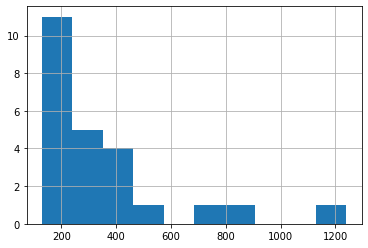

In [123]:
wins['return'].hist()

In [125]:
wins['return'].sum() - 71*100

1040.0

### 2.3.2020年のデータ追加

results

In [126]:
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2020" + str(place).zfill(2) + str(kai).zfill(2) +\
		        str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)


In [129]:
#スクレイピングしてデータを保存
test = scrape_race_results(race_id_list)
for key in test: #.keys()は無くても大丈夫です
    test[key].index = [key] * len(test[key])
results = pd.concat([test[key] for key in test], sort=False) 
results.to_pickle('results_2020.pickle')

  0%|          | 0/7200 [00:00<?, ?it/s]

horse_id,jockey_id

In [137]:
results_t = pd.read_pickle('results_2020.pickle')
race_id_list = results_t.index.unique()
results_new = scrape_race_results2(race_id_list)

  0%|          | 0/3360 [00:00<?, ?it/s]

In [138]:

results_sample = results_new
for key in results_sample: #.keys()は無くても大丈夫です
    results_sample[key].index = [key] * len(results_sample[key])
results_sample2 = pd.concat([results_sample[key] for key in results_sample], sort=False) 
results_sample2.to_pickle('results_sample_2020.pickle')
#results_id = pd.DataFrame(results_new)

In [140]:
results_sample2 = pd.read_pickle('results_sample_2020.pickle')
results_sample2

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id
202001010101,1,6,6,ウインルーア,牝2,54.0,横山武史,1:49.7,NaN,16.0,3.0,438(+4),[東] 青木孝文,2018101626,01170
202001010101,2,2,2,アークライト,牡2,54.0,ルメール,1:50.0,1.3/4,1.9,2.0,510(0),[東] 藤沢和雄,2018105193,05339
202001010101,3,3,3,ギャラントウォリア,牡2,54.0,池添謙一,1:50.1,1/2,1.8,1.0,482(-6),[西] 平田修,2018104800,01032
202001010101,4,1,1,ジュンブーケ,牝2,52.0,亀田温心,1:50.5,2.1/2,22.2,4.0,442(0),[西] 森秀行,2018102410,01176
202001010101,5,4,4,キタノマンゲツ,牡2,54.0,藤岡康太,1:51.0,3,55.7,5.0,426(-8),[西] 中尾秀正,2018100828,01116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202010020812,11,1,1,キスラー,牡4,57.0,武豊,1:45.5,1,6.5,4.0,476(-2),[西] 池江泰寿,2016105042,00666
202010020812,12,8,14,ポンペイワーム,牡4,57.0,浜中俊,1:45.6,クビ,19.8,8.0,522(-8),[西] 石坂正,2016110126,01115
202010020812,13,8,15,アルマトップエンド,牡5,57.0,国分恭介,1:45.9,1.3/4,75.0,14.0,510(0),[西] 佐々木晶,2015102639,01124
202010020812,14,2,3,ノイーヴァ,牝4,55.0,太宰啓介,1:46.7,5,46.1,10.0,488(-12),[西] 安田翔伍,2016110067,01037


idとコース条件のmerge

In [148]:
results = pd.read_pickle('results_sample_2020.pickle')
results_test = pd.read_pickle('results_addinfo_2020.pickle')
results = results.drop(["着順",'枠番','馬番','馬名','性齢','斤量','騎手','タイム','着差','単勝','人気','馬体重','調教師',], axis=1)

In [ ]:
results_addinfo = 0
#results_addinfo = results_test.merge(results,left_index=True,right_index=True,how='right')
#results_addinfo = pd.merge(results_test,results,how='outer')
results_addinfo = pd.concat([results_test,results],axis='columns')
results_addinfo

In [151]:
results_p = preprocessing(results_addinfo)
results_p

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化
202001010101,1,6,6,54.0,16.0,3.0,1800,曇,芝,良,2020-07-25,2018101626,01170,牝,2,438,4
202001010101,2,2,2,54.0,1.9,2.0,1800,曇,芝,良,2020-07-25,2018105193,05339,牡,2,510,0
202001010101,3,3,3,54.0,1.8,1.0,1800,曇,芝,良,2020-07-25,2018104800,01032,牡,2,482,-6
202001010101,4,1,1,52.0,22.2,4.0,1800,曇,芝,良,2020-07-25,2018102410,01176,牝,2,442,0
202001010101,5,4,4,54.0,55.7,5.0,1800,曇,芝,良,2020-07-25,2018100828,01116,牡,2,426,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202010020812,11,1,1,57.0,6.5,4.0,1700,雨,ダート,重,2020-09-06,2016105042,00666,牡,4,476,-2
202010020812,12,8,14,57.0,19.8,8.0,1700,雨,ダート,重,2020-09-06,2016110126,01115,牡,4,522,-8
202010020812,13,8,15,57.0,75.0,14.0,1700,雨,ダート,重,2020-09-06,2015102639,01124,牡,5,510,0
202010020812,14,2,3,55.0,46.1,10.0,1700,雨,ダート,重,2020-09-06,2016110067,01037,牝,4,488,-12


In [152]:
results_p.to_pickle('results_id_2020.pickle')

In [187]:
results = pd.read_pickle('results_id.pickle')
results = prefix(results)
results_p = results
results_p.to_pickle('results_id_2019.pickle')

In [190]:
results_p = pd.read_pickle('results_id_2019.pickle')
results_p

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化
201901010101,1,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16
201901010101,2,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8
201901010101,3,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6
201901010101,4,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8
201901010101,5,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,12,6,11,56.0,120.3,15.0,2600,曇,芝,重,2019-09-01,2013104167,01165,セ,6,458,8
201910021212,13,1,1,54.0,7.5,4.0,2600,曇,芝,重,2019-09-01,2014105643,01178,牡,5,460,2
201910021212,14,2,3,54.0,99.2,12.0,2600,曇,芝,重,2019-09-01,2015102081,01176,牡,4,478,14
201910021212,15,6,12,52.0,17.5,8.0,2600,曇,芝,重,2019-09-01,2016104221,00666,牝,3,468,2


horse_results

In [161]:
results_new = pd.read_pickle('results_sample_2020.pickle')
horse_id_list = results_new["horse_id"].unique()
#馬のデータスクレイピング
horse_results = scrape_horse_results2(horse_id_list)

  0%|          | 0/11495 [00:00<?, ?it/s]

In [162]:
horse_sample = horse_results
for key in horse_sample: #.keys()は無くても大丈夫です
    horse_sample[key].index = [key] * len(horse_sample[key])
horse_sample2 = pd.concat([horse_sample[key] for key in horse_sample], sort=False) 
horse_sample2.to_pickle('horse_data_2020.pickle')

In [165]:
horse_results = pd.read_pickle('horse_data_2020.pickle')
hr = HorseResults(horse_results)
results_m = hr.merge_all(results_p,n_samples=5)
results_m['rank'] = results_m['着順'].map(lambda x:1 if x<4 else 0)
results_m.drop(['着順'],axis=1,inplace=True)
results_m.head()

  0%|          | 0/109 [00:00<?, ?it/s]

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank
202001010101,6,6,54.0,16.0,3.0,1800,曇,芝,良,2020-07-25,2018101626,01170,牝,2,438,4,11.0,0.0,1
202001010101,2,2,54.0,1.9,2.0,1800,曇,芝,良,2020-07-25,2018105193,05339,牡,2,510,0,2.0,280.0,1
202001010101,3,3,54.0,1.8,1.0,1800,曇,芝,良,2020-07-25,2018104800,01032,牡,2,482,-6,2.0,280.0,1
202001010101,1,1,52.0,22.2,4.0,1800,曇,芝,良,2020-07-25,2018102410,01176,牝,2,442,0,5.0,70.0,0
202001010101,4,4,54.0,55.7,5.0,1800,曇,芝,良,2020-07-25,2018100828,01116,牡,2,426,-8,12.0,0.0,0


In [168]:
horse_data_index = pd.read_pickle('horse_data_index.pickle')
horse_data_index

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴
2017105318,2021/12/12,5中山4,晴,8.0,3歳以上1勝クラス,NaN,16.0,2.0,4.0,15.5,...,**,1-1-1-12,36.7-35.4,NaN,558(+6),NaN,NaN,クライミングリリー,NaN,NaN
2017105318,2021/10/24,4東京6,晴,7.0,3歳以上1勝クラス,NaN,9.0,4.0,4.0,6.0,...,**,1-1-1,36.8-34.7,35.0,552(+6),NaN,NaN,ナムラカミカゼ,76.0,NaN
2017105318,2021/09/11,4中山1,晴,8.0,3歳以上1勝クラス,NaN,16.0,4.0,8.0,6.7,...,**,3-3-2-2,36.2-39.6,41.3,546(+14),NaN,NaN,ホウオウセレシオン,NaN,NaN
2017105318,2021/07/17,1福島5,晴,9.0,南相馬特別(1勝クラス),NaN,16.0,5.0,10.0,5.2,...,**,3-3-3-2,34.9-35.9,36.5,532(-38),NaN,NaN,フィデリオグリーン,NaN,NaN
2017105318,2020/12/26,5中山7,晴,9.0,立志賞(1勝クラス),NaN,18.0,6.0,12.0,3.5,...,**,1-1-1-1,37.5-36.8,38.7,570(+18),NaN,NaN,ルトロヴァイユ,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017101106,2020/03/14,1阪神5,雨,2.0,3歳未勝利,NaN,13.0,6.0,9.0,137.1,...,**,5-5-6-7,38.3-37.1,38.2,460(0),NaN,NaN,サンライズプラウ,NaN,NaN
2017101106,2020/02/29,1中京1,曇,2.0,3歳未勝利,NaN,12.0,7.0,10.0,45.4,...,**,8-8-10-9,30.6-38.4,38.7,460(-2),NaN,NaN,ワンダークンナパー,NaN,NaN
2017101106,2020/02/09,2京都4,晴,2.0,3歳未勝利,NaN,15.0,2.0,3.0,40.9,...,**,1-1-1-1,38.3-38.3,40.1,462(0),NaN,NaN,クールインパクト,NaN,NaN
2017101106,2020/01/25,1京都8,曇,3.0,3歳未勝利,NaN,11.0,7.0,9.0,28.0,...,**,10-9-9-7,36.9-37.8,38.3,462(+14),NaN,NaN,フームスムート,51.0,NaN


払い戻し

In [177]:
results_p = pd.read_pickle('results_id_2020.pickle')
train,test = split_data(results_p)

In [182]:
race_id_list = test.index.unique()
return_tables = scrape_return_tables(race_id_list)

  0%|          | 0/1008 [00:00<?, ?it/s]

In [183]:
for key in return_tables: #.keys()は無くても大丈夫です
    return_tables[key].index = [key] * len(return_tables[key])
results_tables1 = pd.concat([return_tables[key] for key in return_tables], sort=False)
results_tables1.to_pickle('return_tables_2020.pickle')

In [185]:
results_tables1 = pd.read_pickle('return_tables_2020.pickle')
results_tables1

,0,1,2,3
202001020708,単勝,1,590,3
202001020708,複勝,1br5br7,210br200br280,3br2br6
202001020708,枠連,1 - 3,1080,5
202001020708,馬連,1 - 5,1500,4
202001020708,ワイド,1 - 5br1 - 7br5 - 7,"570br1,350br1,260",3br16br15
...,...,...,...,...
202006050805,馬連,12 - 13,760,3
202006050805,ワイド,12 - 13br12 - 15br13 - 15,"360br9,180br1,660",3br63br17
202006050805,馬単,12 → 13,2570,9
202006050805,三連複,12 - 13 - 15,14390,56
